## Notebook 7 - Search of products in PubChem

In [ ]:
%run ../common.py

In [32]:
df_products = pd.read_csv(filepath_results + 'Substrates_VB_clean.csv', encoding='utf8', usecols=('Name',))
df_products = df_products.drop_duplicates('Name', ignore_index=True)


In [33]:
import requests

def wildcard_search_pubchem(query):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pccompound",
        "term": f"{query} *glucoside",
        "retmode": "json",
    }
    
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        if 'esearchresult' in data and 'idlist' in data['esearchresult']:
            cids = data['esearchresult']['idlist']
            return cids
        else:
            return []
    else:
        return []

def get_compound_names(cids):
    names = {}
    if not cids:
        return names
    
    # Request compound names based on CIDs
    cid_list = ",".join(cids)
    base_url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid_list}/property/IUPACName/JSON"
    
    response = requests.get(base_url)
    
    if response.status_code == 200:
        data = response.json()
        if 'PropertyTable' in data and 'Properties' in data['PropertyTable']:
            for compound in data['PropertyTable']['Properties']:
                cid = compound.get('CID')
                name = compound.get('IUPACName')
                names[cid] = name
    return names

In [34]:
query_strings = df_products['Name'].to_list()
cids = []
names = []
for query in tqdm(query_strings):
    cid = wildcard_search_pubchem(query)
    name = get_compound_names(cid)
    cids.append(cid)
    names.append(name)

100%|██████████| 434/434 [02:55<00:00,  2.47it/s]


In [35]:
df_products['Product_Name'] = [list(name.values()) for name in names]
df_products['CID'] = cids

In [36]:
df_products['in_pubchem'] = [bool(x) for x in df_products['CID']]

In [37]:
df_products['in_pubchem'].value_counts()

in_pubchem
False    358
True      76
Name: count, dtype: int64

In [38]:
# Let us add a column indicating how many enzymes turned over each substrate

df_sd = pd.read_csv(filepath_results + 'Screening_results_CosineScore_0.85.csv')
df_sd = df_sd.drop_duplicates(['Name', 'Enzyme_name'])
enzymes_react = dict(df_sd['Name'].value_counts())

In [39]:
df_products['Enzymes_react'] = df_products['Name'].apply(lambda x: enzymes_react.get(x, 0))


In [40]:
df_products['reacted'] = df_products['Enzymes_react'] > 0

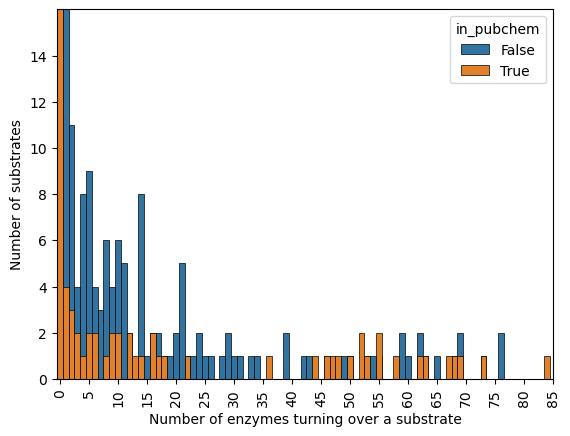

In [41]:
sns.countplot(x='Enzymes_react', 
              hue='in_pubchem', 
              data=df_products,
              dodge=False,
              native_scale=True,
              edgecolor='k',
              width=1.0,
              linewidth=0.5)
plt.ylim([0,16])
plt.xlim([-0.5,85])
plt.xlabel('Number of enzymes turning over a substrate')
plt.ylabel('Number of substrates')
plt.xticks(rotation=90)
plt.xticks(range(0, 86, 5))
plt.yticks(range(0, 16, 2))
plt.show()

In [42]:
df_products.to_csv(filepath_results + 'potential_products_pubchem.csv', index=False)

In [43]:
df_products = pd.read_csv(filepath_results + 'potential_products_pubchem.csv')

In [44]:
### Figure 2b

pd.crosstab(df_products['reacted'], df_products['in_pubchem'], margins=True)

in_pubchem,False,True,All
reacted,,,
False,218,29,247
True,140,47,187
All,358,76,434
